# RNA-Seq analysis comparing human classical vs. nonclassical monocytes
This analysis compares the difference in gene expressions of classical vs. nonclassical monocytes from a clinical cohorts with the two cell types purified from each of 16 persons (ignore unpaired samples). Paired ascertained *t*-test will be used to identify the significantly differentially expressed genes (SDEGs). The goal is to sensitively identify the SDEGs while maintaining strigent false discovery control.

First, we import analysis tools.

In [1]:
import sys, imp, time, pandas as pd
%pylab inline
import scipy.stats as ss
if 'rudolphLab/scripts' not in sys.path: sys.path.insert(0, '/Users/jiangnan/Documents/rudolphLab/scripts')
import rosely
imp.reload(rosely)
from rosely import *

Populating the interactive namespace from numpy and matplotlib
Rosely version: 1.3.0
import time: 2019-05-13 19:29:38.237577+02:00
Rosely version: 1.3.0
import time: 2019-05-13 19:29:38.242500+02:00


## Load the count matrix data:
The RNA-seq count matrix preprocessed by STAR-HTSeq was kindly provided by Claire Williams. For detailed descriptions, see [Williams et al. (2017)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1457-z). The raw data is available by SRA accession [SRP082682](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=srp082682).

Normalize different samples by the average of the 25% all rows whose mean counts are just above the the medium of expressed genes with mean count above a threshold.

In [2]:
cr = CountReads(
    'SrHt_monocyte_expressionMatrix.txt', # count matrix file name. It can be text or Excel files.
    sep='\t',                    # field separator, this is a tab-separated file.
    group_sample_sep='ical',     # the heading has format classical01	classical02.
    igroup=1,           # the first igroup strings after split by group_sample_sep will
                        # be used as the the group name
    has_groups=True,    # Sample names contain info for experimental groups, see above.
    sample_name_transform=None, # A function to transform sample names, in case the sample
                                # names cannot be easily separated into groups and samples.
    is_microarray=False, # Rosely support read microarray data, Microarray data should have 
                         # one column of Detection_Pval ('pval' is used for patter matching) 
                         # for (after) each data column. Data with p-value > 0.05 is set to NaN.
   # **kwargs,           # Additional keyword arguments can be passed to pandas read_excel
                         # or read_csv functions.
   )

cr.normalize_data(normalize_by='upper quantile4', # Use upper 4-quantile for cross-sample normalization.
                  normcutoff=10)     # Only rows with count > 10 will be used for normalization.
print('Number of genes:', len(cr.seqids))
groups = list(cr.presences.keys())
print('groups:', groups)
print('The reference counts to be normalized to for each sample:')
cr.nRefs

Number of genes: 62069
groups: ['class', 'nonclass']
The reference counts to be normalized to for each sample:


{('class', '01'): 52.67479674796748,
 ('class', '02'): 138.63703120902176,
 ('class', '03'): 186.9931812221348,
 ('class', '04'): 65.65958562811434,
 ('class', '05'): 130.88985051140833,
 ('class', '07'): 84.56622082349855,
 ('class', '08'): 100.99711513244165,
 ('class', '09'): 48.8164175190139,
 ('class', '10'): 49.4686598478888,
 ('class', '11'): 97.77576711250984,
 ('class', '12'): 104.55100970364542,
 ('class', '13'): 126.181222134802,
 ('class', '14'): 109.5827432467873,
 ('class', '15'): 63.23498557566221,
 ('class', '16'): 84.95882507212168,
 ('class', '17'): 148.44872803566744,
 ('class', '18'): 23.366902701285078,
 ('nonclass', '01'): 38.60162601626016,
 ('nonclass', '02'): 74.0514030946761,
 ('nonclass', '03'): 234.22029897718332,
 ('nonclass', '04'): 111.99554156831891,
 ('nonclass', '05'): 190.56517178075006,
 ('nonclass', '06'): 142.53868345135064,
 ('nonclass', '07'): 92.2087595069499,
 ('nonclass', '08'): 152.3252032520325,
 ('nonclass', '09'): 36.78914240755311,
 ('non

### Remove samples that do not form pairs.

In [3]:
del cr.normdata['class', '15']
del cr.normdata['nonclass','06']

## Distribution of reads for the 1st sample

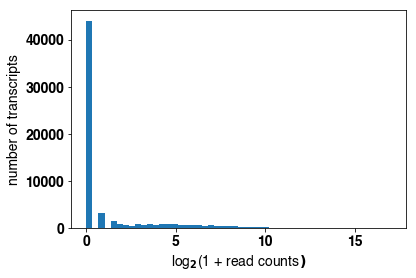

In [4]:
group = cr.data[groups[0]]
d = log2(1 + array(group[list(group.keys())[0]].values))
hist(d[abs(d)<10000], 50);
xlabel('log$_2$(1 + read counts$ ^{{}} )$'); ylabel('number of transcripts');

## How cross-sample normalized data look like for an experimental group

In [5]:
cr.normdata['class'].head()

,01,02,03,04,05,07,08,09,10,11,12,13,14,16,17,18
UNIQID,,,,,,,,,,,,,,,,
ENSG00000000003,2.189847,0.000000,0.000000,0.000000,0.00000,0.000000,5.710546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.292559,0.00000,0.000000
ENSG00000000419,453.298246,1233.063709,360.249709,47.433174,2.64382,98.209191,454.559423,259.922181,568.952806,409.368861,1080.117550,120.669014,341.051060,319.062620,456.11902,513.391591
ENSG00000000457,142.340029,0.000000,23.440906,10.540705,0.00000,0.000000,25.126400,108.694730,69.953214,48.369231,17.652585,0.000000,10.526267,57.023958,0.00000,64.173949
ENSG00000000460,0.000000,0.000000,35.778225,86.082427,0.00000,4.092050,18.273746,18.903431,34.976607,53.088181,33.098597,0.000000,12.631521,95.039929,0.00000,24.682288


## SDEG identification by ascertained *t*-test
This part identifies the SDEGs by ascertained t-test (called in function `count_analysis`). The neutrality-controlled p-values are controlled in such a way that most genes will have values expected by random chance so that the identified genes really stand out compared to most other genes. Local false discovery rate (LFDR) is the probability for each gene to be false discovery. 

SVA pop of design variable for ridge regression: 0.457625100139
0.432; iterations:0 r0:0.221, re:0.416, a:0.81133 lsq para:[-0.0143151  -0.22754909]
iterations:1 r0:0.150, re:0.362, a:0.70405 lsq para:[-0.03936505 -0.2454256 ]
iterations:2 r0:0.104, re:0.328, a:0.64409 lsq para:[-0.05610816 -0.29230824]
iterations:3 r0:0.074, re:0.305, a:0.60751 lsq para:[-0.06487556 -0.29841512]
iterations:4 r0:0.054, re:0.291, a:0.58619 lsq para:[-0.07030436 -0.30113745]
iterations:5 r0:0.050, re:0.287, a:0.58141 lsq para:[-0.07127408 -0.29747555]
iterations:6 r0:0.048, re:0.286, a:0.57939 lsq para:[-0.07161376 -0.29475498]
iterations:7 r0:0.047, re:0.285, a:0.57828 lsq para:[-0.07179885 -0.29315728]
iterations:8 r0:0.046, re:0.285, a:0.57772 lsq para:[-0.07189131 -0.29234695]
iterations:9 r0:0.046, re:0.285, a:0.57749 lsq para:[-0.07193105 -0.29205939]
iterations:10 r0:0.046, re:0.285, a:0.57738 lsq para:[-0.07194959 -0.29189667]
iterations:11 r0:0.046, re:0.284, a:0.57727 lsq para:[-0.07196885 -0.2

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
ENSG00000137801,0.000264,-6.464104,1.019007e-10,-11.728282
ENSG00000169508,0.002536,-5.373890,7.705593e-08,-7.688795
ENSG00000143546,0.002598,-5.362712,8.198168e-08,-8.063907
ENSG00000169429,0.005695,-4.999276,5.754589e-07,-5.089643
ENSG00000203747,0.009155,4.778529,1.765825e-06,7.063530


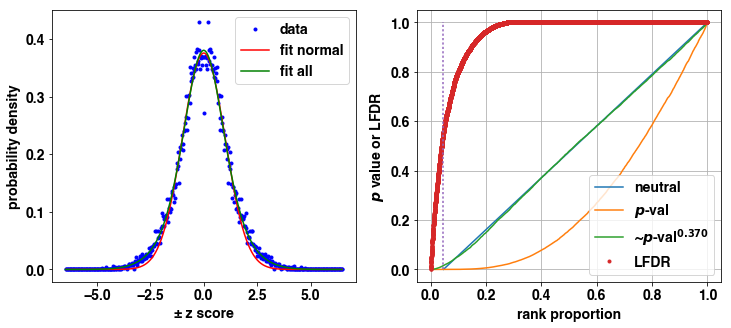

In [6]:
t0 = time.time()
nd = cr.normdata
res = count_analysis(
    # Non-default parameters:
    [nd['class'],       # A list of groups to compare. The sign of change will be group i>0 
     nd['nonclass']],   # subtracting group i-1
    paired=True,        # If doing paired t-test, sample names between samples must match.
    transform='log5',   # Transform data x by log(5 + x). 'log5' can also be replaced by a number
                        # to do power transformation. Default 1 for no transform.
    minmean=10,         # Minimum mean of all samples before transform to be included in the 
                        # analysis. Default nan.
    weighted=True,      # When True and sample_weights is not set, each sample will be weighted by
                        # inverse mean variances (Squared Errors divided by sum SE) of all genes.
    do_SVA=True,        # Surrogate variable analysis (SVA) to remove hidden variables influence.
    nSV=5,              # Number of surrogate variables to incorporate. Should be smaller than the
                        # total sample size. Larger values may cause overfitting, although ridge-
                        # regularization can mitigate this problem. Larger values (e.g. 15) 
                        # produced also more SDEGs here, but the generality has not been tested.
    debug=True,         # Saves internal variables into res.vbs, necessary for plotting variances.

    
    # Default parameters:
    pre_neutralize=True,# Partially pre-deflate inflated degrees of freedom based on power of 
                        # p-values before ascertained t-test.
    method='ascertained_ttest', # if method is set to non-default values, normal t-test is used.
    controls=None,      # A list of control genes for cross-group normalization.
    sample_weights=None,# A dict for weight of each sample. Weight must be <=1 and indicate the
                        # effective sample size. If set, it will overwrite parameter 'weighted'.
    minn=1.25,          # Minimum number of total replicates required to include in the analysis.
    drop_missmatch=True,# If paired, samples with names not matching the other group are dropped.
    equalV=False,       # For un-paired test, Welch's t-test is used. If equalV=True, Student's
                        # t-test is used. Both can be used as downstream of ascertained t-test 
                        # or used independently if method is set to non-default.
    span=None,          # span (0 < span < 1) for loess fit. By default, it is adaptive selected.
    ridge=True,         # Whether regularization by ridge regression will be performed in SVA.
    penaltyRatioToSV=0.2, # How much the design variables are penalized relative to the SVs.
    normalize_min_pval=0.1, # Only genes with p-values above this value will be used as controls
                            # for intra-group sample normalization and cross-group normalization.
    parallel=True,      # Parallel computation to speed up; but not easy for debug.
    neutralize=True,    # Neutrality-controlled p-values will be calculated and put in res.results 
                        # If False, raw p-values will be used. If pre_neutralize=True, p-values
                        # will NOT be corrected to the expected values without pre-neutralization.

    # There are also default parameters for function neup (to calculate neutrality-controlled 
    # p-values). See below.
    )
print('Computation time (s):', time.time() - t0)
print('Top 5 differentially expressed genes:')
res.results.head(n=5)

## Interpretation of the results
The first thing one should look at is the power of *p*-values (0.37 here) that transforms the original *p*-values to the "neutral" straight line. This power is small (unbiased data has a power of 1), suggesting that the results will contain huge false significance if not corrected. The p-values are sysmtematically biased towards small values, indicating systematic biases. Possible sources of biases include sample correlation among participant caused by genetic, developmental and environmental factors subgrouping the participants, non-identical treatment during sample preparation, and some biases possibly introduced by the statistical analysis here (although Rosely is developed with very high priority to avoid such biases).

Why do sample correlations cause strong systematic biases? Because with strong sample correlations among subgroups of samples, each of the samples behave statistically like technical replicates instead of independent replicates. Doubling the technical replicates would cause *all* *p*-values to get squared and produce a power of *p*-values as 0.5. 

On the other hand, the LFDRs calculated from the neutrality-controlled *p*-values show that some genes (with LFDR smaller than a cutoff, say 0.4 or 0.2) are still identified as SDEGs. The LFDRs are calculated, shown on the left panel, as the red curve "fit normal" (standard normal distribution as expected by random chance) divided by the green curve "fit all" (the actual density distribution), with some minor adjustments. 

## What happens if there are true global changes in gene expression?
Global changes can also explain the low power of *p*-values and are possible, given the two cell types are different. However, this justification may not be strong enough. In this monocyte study, to assume global changes, all the participants should have the same degrees of genealogical relatedness with each other and always live in almost identical environment (factors such as sex and age may also influence), and the samples have to be subsequentially processed identically. These conditions are extremely difficult to guaranttee. To prove global changes, one'd better do it in amimal models such as lab mice.

Here we just show how it would change the result and identify more SDEGs.

iterations:0 r0:0.221, re:0.416, a:0.81133 lsq para:[-0.0143151  -0.22754909] SE:0.0000005
iterations:1 r0:0.213, re:0.410, a:0.79738 lsq para:[-0.01821361 -0.23159514] SE:0.0000005
iterations:2 r0:0.205, re:0.404, a:0.78489 lsq para:[-0.02254983 -0.24737936] SE:0.0000005
iterations:3 r0:0.198, re:0.398, a:0.77348 lsq para:[-0.02564276 -0.253858  ] SE:0.0000005
iterations:4 r0:0.191, re:0.393, a:0.76237 lsq para:[-0.02823508 -0.25653055] SE:0.0000004
iterations:5 r0:0.184, re:0.388, a:0.75277 lsq para:[-0.03022746 -0.25652441] SE:0.0000004
iterations:6 r0:0.178, re:0.383, a:0.74348 lsq para:[-0.03223489 -0.25773862] SE:0.0000004
iterations:7 r0:0.172, re:0.379, a:0.73483 lsq para:[-0.0338999  -0.25666463] SE:0.0000003
iterations:8 r0:0.166, re:0.374, a:0.72620 lsq para:[-0.03538134 -0.25332737] SE:0.0000003
iterations:9 r0:0.160, re:0.370, a:0.71797 lsq para:[-0.03691659 -0.25139642] SE:0.0000003
iterations:10 r0:0.154, re:0.366, a:0.71019 lsq para:[-0.03814321 -0.24647693] SE:0.000000

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
ENSG00000137801,1.887801e-07,-7.239050,4.518372e-13,-11.728282
ENSG00000169508,3.567093e-05,-6.031181,1.627656e-09,-7.688795
ENSG00000143546,3.746597e-05,-6.018799,1.757160e-09,-8.063907
ENSG00000169429,1.739786e-04,-5.616225,1.951742e-08,-5.089643
ENSG00000203747,4.161665e-04,5.371720,7.798917e-08,7.063530


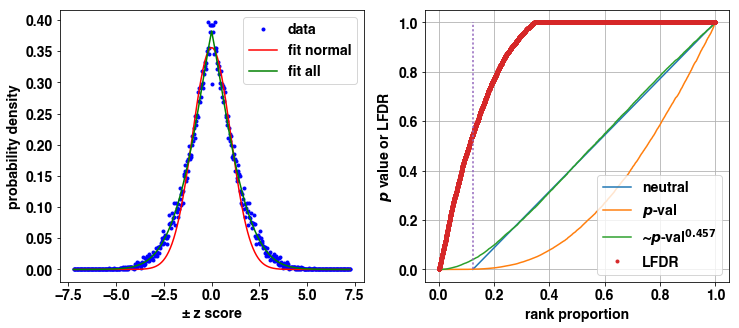

In [7]:
res.neutralize_p_values(
    global_changes=True,# Global changes are assumed and neup will less aggressively push p-values
                        # to neutral values and identify more SDEGs. However, strong justification
                        # is needed for this, e.g., no intra-group sample correlations are likely. 
    # Default parameters:
    LFDRthr0=0.5,    # The threshold LFDR between random and non-random p-values.
    minr0=0,         # Minimum assumed rank proportion of neutral genes.
    fine_tune=True,  # Whether p-values will be fitted by y = x ** (a + b*y**c) on log scale.
    nbins=50,        # # of bins to partition z-scores to count frequency. But this is only
                     # proportional, the real number is adaptively changed based on data number. 
    df_fit=5,        # degrees of polynomials in Poisson regression of z-score density function.
    with_plot=True,  # Plot the z-score densities, p-values and LFDRs. Ouput will be verbose.
    new_figure=True, # A new figure will be created for the plot.
    plotLFDR = True, # The axis of z-score densities for calculating LFDRs will be plotted.
    data_name='data',# The string to display in the legend on the z-score density function plot.
    subplot_label='',# One can use something like a, b, c ... or label each axis.
)
print('Top 5 differentially expressed genes:')
res.results.head(n=5)

Let us convert the results back to the original calculation by calling the same function without setting the `global_changes` parameter. We do not need to plot anymore, so set `with_plot=False`.

In [8]:
res.neutralize_p_values(with_plot=False)
res.results.head()

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
ENSG00000137801,0.000264,-6.464104,1.019007e-10,-11.728282
ENSG00000169508,0.002536,-5.373890,7.705593e-08,-7.688795
ENSG00000143546,0.002598,-5.362712,8.198168e-08,-8.063907
ENSG00000169429,0.005695,-4.999276,5.754589e-07,-5.089643
ENSG00000203747,0.009155,4.778529,1.765825e-06,7.063530


## Internal of ascertained *t*-test: distribution of normalized variance of genes
Sampling SD is the amount of variation expected by random chance.

Prior gene SD (standard deviation) is the calculated expected SD of normalized variance of each gene.  

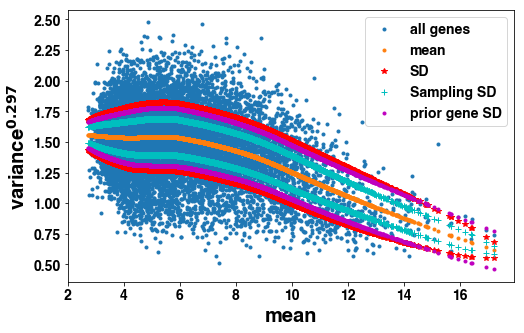

In [9]:
res.plot_variance()

## Total number of genes with LFDR < 0.2 and LFDR < 0.4
LFDR (local false discovery rate) is the chance for a gene to be false discovery after adjustment for multiple comparisons.

Why two cutoffs here? 0.2 (or smaller, e.g., 0.1) is suggested to use in case you need high reliability for the identified genes. E.g., if you want to experimentally test each gene, the cost of each false positive can be high.

0.4 (or slightly larger, e.g., 0.6, but LFDRs larger than 0.6 could be inaccurate estimates, depending on the shape of the LFDR curve) can be used to simply look at the scope of gene distribution by methods such as Gene Ontology analysis. In this case, the aggregate effects of the top genes are usually not very sensitive to some errors of individual genes. Including more genes could even be more reliable.

In [10]:
sum(res.LFDR<0.2)

143

In [11]:
sum(res.LFDR<0.4)

362

In [12]:
res.results.loc[res.LFDR<0.4].tail()

,LFDR,Controlled z-score,Controlled p-value,log2 fold change
ENSG00000100644,0.396259,-2.717429,0.006579,-1.595918
ENSG00000158195,0.396293,2.717358,0.006581,2.525517
ENSG00000196083,0.397226,-2.715459,0.006618,-2.976205
ENSG00000173083,0.397372,-2.715163,0.006624,-3.411277
ENSG00000114738,0.399223,2.711404,0.006700,2.434212


## Gene Ontology analysis
### Load ontology data:

Package [`goatools`](https://github.com/tanghaibao/goatools) is a dependency for downloading Gene Ontology data. However, the statistical analysis is not performed by it. `Rosely` comes with its own methods for statistical calculations (Fisher's exact test for *p*-value calculation) to incorporate LFDRs into the analysis and to do KEGG pathway analysis by the same functions with the same outputs. This also makes it easier to pipe the results from ascertained *t*-test to downstream analysis.

In [13]:
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()
obodag = GODag(obo_fname)
geneid2gos = read_ncbi_gene2go(gene2go, taxids=[9606])

  EXISTS: go-basic.obo
  EXISTS: gene2go
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2018-05-28) 47,248 GO Terms
  19,447 items READ: gene2go


### Convert gene ids

Gene id conversion depends on [MyGene](http://docs.mygene.info/projects/mygene-py/en/latest/). It converts Ensembl transcript ids into gene ids and symbols (newest).

In [14]:
ids = getGeneId(res.results.index, species='human')
res.results['geneid'] = ids['geneid']
res.results['symbol'] = ids['symbol']
rr = res.results.set_index('geneid').dropna()
rr.shape

Querying ensemblgene,symbol 1 ~ 1000 1001 ~ 2000 2001 ~ 3000 3001 ~ 4000 4001 ~ 5000 5001 ~ 6000 6001 ~ 7000 7001 ~ 8000 8001 ~ 9000 9001 ~ 10000 10001 ~ 11000 11001 ~ 12000 12001 ~ 12546 


(10195, 5)

### Use all analyzed genes as population (background)

In [15]:
from goatools.ratio import get_terms
population = rr.index
go2popitems = get_terms("population", population, geneid2gos, obodag, None)
GOs = {}
for go in sorted(go2popitems): 
    if len(go2popitems[go]) >= 5: # Pre-clean GO terms unlikely to be very significant (too few genes in population)
        GOs[go] = {'geneid':go2popitems[go], 'name':obodag[go].name}

### Analyze the enrichment of the top genes with LFDR < 0.4
Please notice that "fit normal" in the *z*-score density plot is not well fitted. This is because neutrality-controlled *p*-values are not used here since the biases are difficult to be categorized as sample correlations. The most likely reason for the bias is that Gene Ontology terms are not independent. In many cases, several terms may be identical in terms of contained genes. This would distort the *p*-value and *z*-score distribution and cause inaccurate calculations of LFDRs. However, this problem may NOT be as severe as one would imagine, because stacking more non-independent GO terms into the analysis only bias the distribution *linearly*. (In contrast, sample correlations distort *p*-values *exponentially*.)

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0005886,plasma membrane,2.616785e-14,5.661465e-18,137 / 341,2040 / 10195,2.01,137,2040,"MYO1G 3.24, IL12RB1 3.23, EPS8 3.91, IL13RA1 -..."
GO:0043312,neutrophil degranulation,1.768016e-12,4.578316e-16,49 / 341,383 / 10195,3.82,49,383,"SELL -4.69, CRISPLD2 -5.11, CD93 -6.69, S100A8..."
GO:0005887,integral component of plasma membrane,1.353075e-09,5.068659e-13,58 / 341,611 / 10195,2.84,58,611,"SELL -4.69, SELPLG 4.79, IFNGR2 -2.03, LRRC8C ..."
GO:0006954,inflammatory response,2.316991e-08,1.076185e-11,30 / 341,203 / 10195,4.42,30,203,"S100A8 -8.06, S100A9 -4.51, THBS1 -11.73, CSF1..."
GO:0005576,extracellular region,9.968028e-08,5.287448e-11,57 / 341,664 / 10195,2.57,57,664,"CRISPLD2 -5.11, S100A6 -1.67, S100A8 -8.06, S1..."


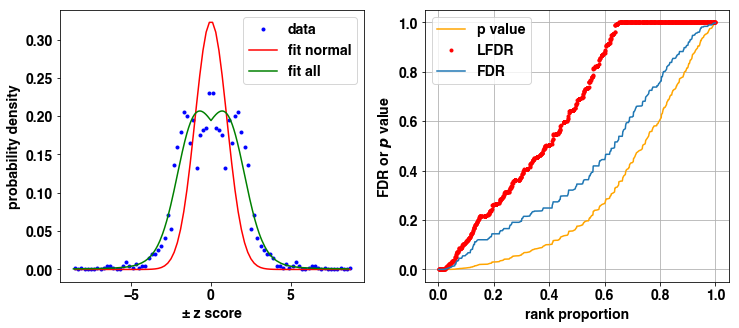

In [16]:
top_genes = rr[rr['LFDR']<0.4].index
goenriched = enrichment_analysis(top_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
goenriched[goenriched['LFDR']<0.4].head()

### Analyze the enrichment of the top *up-regulated* genes with LFDR < 0.4

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0005886,plasma membrane,0.000239,5.121473e-07,58 / 154,2040 / 10195,1.88,58,2040,"SELPLG 4.79, RHOC 3.94, MYO1G 3.24, RHOG 1.99,..."
GO:0002250,adaptive immune response,0.000255,5.443958e-07,10 / 154,79 / 10195,8.38,10,79,"CSK 3.12, LILRB1 2.96, CD79B 5.76, PIK3CG 3.65..."
GO:0043312,neutrophil degranulation,0.003420,9.595480e-06,19 / 154,383 / 10195,3.28,19,383,"RAB37 3.93, SLC44A2 4.84, STXBP2 3.07, RHOG 1...."
GO:0008360,regulation of cell shape,0.006327,2.226481e-05,10 / 154,118 / 10195,5.61,10,118,"RHOC 3.94, RHOG 1.99, ITGB2 3.41, EPS8 3.91, C..."
GO:0035579,specific granule membrane,0.007621,2.928525e-05,8 / 154,74 / 10195,7.16,8,74,"RAB37 3.93, SLC44A2 4.84, ITGB2 3.41, TMBIM1 2..."


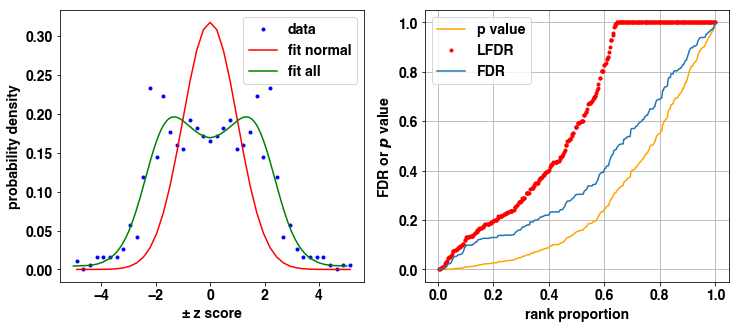

In [17]:
top_up_genes = rr[(rr['LFDR']<0.4) & (rr['log2 fold change']>0)].index
up_goenriched = enrichment_analysis(top_up_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
up_goenriched[up_goenriched['LFDR']<0.5].head(n=5)

### Analyze the enrichment of the top *down-regulated* genes with LFDR < 0.4

,GO terms,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
GO:0005576,extracellular region,3.635927e-10,3.076396e-13,43 / 187,664 / 10195,3.53,43,664,"CRISPLD2 -5.11, S100A6 -1.67, S100A8 -8.06, S1..."
GO:0006954,inflammatory response,4.574216e-09,4.281983e-12,23 / 187,203 / 10195,6.18,23,203,"S100A8 -8.06, S100A9 -4.51, THBS1 -11.73, CD14..."
GO:0005886,plasma membrane,4.792690e-09,4.496131e-12,79 / 187,2040 / 10195,2.11,79,2040,"IFNGR2 -2.03, SELL -4.69, ACSL1 -2.32, S100A6 ..."
GO:0005887,integral component of plasma membrane,8.572182e-09,8.268015e-12,39 / 187,611 / 10195,3.48,39,611,"SELL -4.69, IFNGR2 -2.03, LRRC8C -4.62, SLC38A..."
GO:0043312,neutrophil degranulation,2.358894e-08,2.399754e-11,30 / 187,383 / 10195,4.27,30,383,"SELL -4.69, CRISPLD2 -5.11, CD93 -6.69, S100A8..."


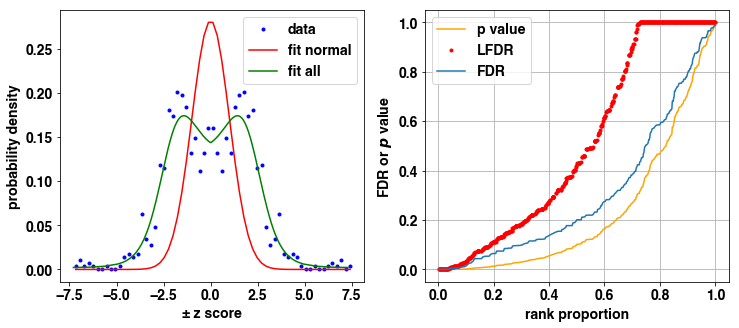

In [18]:
top_down_genes = rr[(rr['LFDR']<0.4) & (rr['log2 fold change']<0)].index
down_goenriched = enrichment_analysis(top_down_genes, population, GOs, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')
down_goenriched[down_goenriched['LFDR']<0.6].head(n=5)

## Save the Gene Ontology analysis to file

In [19]:
import os
if not os.path.isdir('monocyte'): os.mkdir('monocyte')
pd.Panel({'all DEGs':goenriched,
          'up-regulated':up_goenriched,
          'down-regulated':down_goenriched}).to_excel('monocyte/Nonclassical.vs.classical.monocytes.GO.analysis.xlsx')

## KEGG pathway analysis
rosely.pathwayanalysis is used for analysis. This module is dependent on BioPython. This may take a while for the first time.
### Load KEGG data:

In [20]:
pathways = load_all_kegg_pathways(species_code='hsa')

### Gene enrichment in KEGG pathways for the top genes with LFDR < 0.4

Enriched pathways (fold = study / background):


,Pathways,LFDR,p value,study,background,enrich fold,n,N,geneid & log2 fold change
path:hsa04060,Cytokine-cytokine receptor interaction,0.000118,5.886618e-07,15 / 341,91 / 10195,4.93,15,91,"IL1B -4.31, CSF3R -3.08, IL1R1 -3.52, IFNGR2 -..."
path:hsa04145,Phagosome,0.000230,1.382884e-06,16 / 341,110 / 10195,4.35,16,110,"CD14 -3.85, HLA-C 1.89, HLA-DMA -2.5, CLEC7A -..."
path:hsa04514,Cell adhesion molecules (CAMs),0.000276,1.728758e-06,13 / 341,74 / 10195,5.25,13,74,"SELL -4.69, HLA-C 1.89, SELPLG 4.79, HLA-DMA -..."
path:hsa04640,Hematopoietic cell lineage,0.000331,2.159138e-06,11 / 341,53 / 10195,6.21,11,53,"CD9 -4.75, IL1B -4.31, CD14 -3.85, CSF3R -3.08..."
path:hsa05132,Salmonella infection,0.001354,1.099597e-05,11 / 341,62 / 10195,5.30,11,62,"IL1B -4.31, CD14 -3.85, IFNGR2 -2.03, RHOG 1.9..."
path:hsa05150,Staphylococcus aureus infection,0.002754,2.446683e-05,8 / 341,34 / 10195,7.03,8,34,"SELPLG 4.79, HLA-DMA -2.5, FCGR3A 7.06, C1QA 3..."
path:hsa05144,Malaria,0.003633,3.344858e-05,7 / 341,26 / 10195,8.05,7,26,"IL1B -4.31, ITGB2 3.41, SDC2 -4.11, THBS1 -11...."
path:hsa04657,IL-17 signaling pathway,0.008016,8.287905e-05,9 / 341,51 / 10195,5.28,9,51,"IL1B -4.31, S100A8 -8.06, S100A9 -4.51, CXCL2 ..."
path:hsa05140,Leishmaniasis,0.011943,1.326224e-04,9 / 341,54 / 10195,4.98,9,54,"IL1B -4.31, HLA-DMA -2.5, IFNGR2 -2.03, FCGR3A..."
path:hsa04216,Ferroptosis,0.012789,1.439512e-04,7 / 341,32 / 10195,6.54,7,32,"ACSL1 -2.32, SLC7A11 -4.35, CP -4.89, LPCAT3 4..."


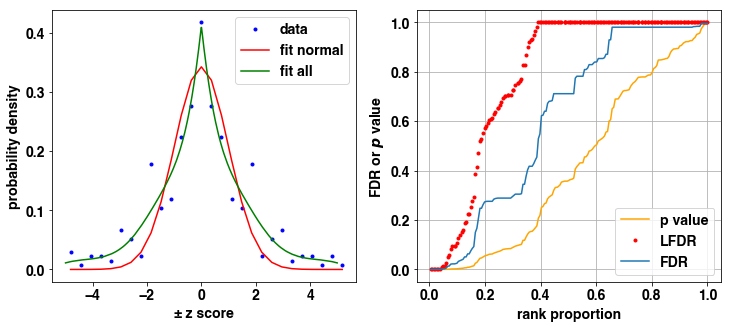

In [21]:
top_genes = rr[rr['LFDR'] < 0.4].index
enriched = enrichment_analysis(top_genes, population, pathways, tosymbols=rr['symbol'], 
                                 values=rr['log2 fold change'], valuename='log2 fold change')

kegggenes = []
for pw in (enriched[enriched['LFDR']<0.4]).index:
    symbol = pathways[pw]['gene_symbol']
    kegggenes.extend(symbol)
print('Enriched pathways (fold = study / background):')
enriched[enriched['LFDR']<0.2]

## Save to file

In [22]:
enriched[enriched['LFDR']<0.4].to_excel('monocyte/RNA-seq.Gene_KEGG_pathway_enrichment.xlsx')

## Draw the pathways to file
The color of the boxes indicates statistical significance and is calculated as neutrality-controlled z-scores times their absolute values. Positive values are shown in red, indicating evidence for up-regulation in nonclassical monocytes; negative values in blue.

In [23]:
draw_kegg_pathways(enriched[enriched['LFDR']<0.4], rr, overlap_cutoff=2,
                   colorcolumn='Controlled z-score', folder='monocyte/pathway images') 